# Imports and API

In [1]:
import sys

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product

sys.path.append("../../")

from datasets.simulated.data_generators import (
    LookupTableDataGenerator,
    SyntacticDataGenerator,
)

# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)


def topological_similarity(w, z):
    w = F.one_hot(torch.from_numpy(w)).float().numpy().reshape(w.shape[0], -1)
    z_rdm = pdist(z, metric="euclidean")
    w_rdm = pdist(w, metric="cityblock")
    topsim = pearsonr(z_rdm, w_rdm).statistic
    return topsim

# Simulations

## Lookup table

In [2]:
num_words = 16
vocab_size = 10
z_dim = 64
noise_ratio = 0.01
n_samples = 1000
n_seeds = 10
per_sample = True

### Varying the sentence length

In [3]:
data_sentence_length = []
for k in tqdm(range(1, z_dim + 1)):
    for i in enumerate(range(n_seeds)):
        if z_dim % k != 0:
            continue
        data_gen = LookupTableDataGenerator(
            num_words=k,
            vocab_size=vocab_size,
            z_dim=z_dim,
            disentanglement=1,
            noise_ratio=noise_ratio,
            random_seed=i,
        )
        w, z = data_gen.sample(n_samples)
        c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
        topsim = topological_similarity(w, z)
        data_sentence_length.append(
            {
                "Sentence length": k,
                "Vocabulary size": vocab_size,
                "Representation dimensionality": z_dim,
                "Disentanglement": 1,
                "Noise ratio": noise_ratio,
                "Compositionality": c,
                "Topological similarity": topsim,
            }
        )
data_sentence_length = pd.DataFrame(data_sentence_length)

100%|██████████| 64/64 [00:15<00:00,  4.11it/s]


### Varying vocabulary size

In [5]:
data_vocab_size = []
for v in tqdm(range(2, 100 + 1)):
    for i in enumerate(range(n_seeds)):
        data_gen = LookupTableDataGenerator(
            num_words=num_words,
            vocab_size=v,
            z_dim=z_dim,
            disentanglement=1,
            noise_ratio=noise_ratio,
            random_seed=i,
        )
        w, z = data_gen.sample(n_samples)
        c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
        topsim = topological_similarity(w, z)
        data_vocab_size.append(
            {
                "Sentence length": num_words,
                "Vocabulary size": v,
                "Representation dimensionality": z_dim,
                "Disentanglement": 1,
                "Noise ratio": noise_ratio,
                "Compositionality": c,
                "Topological similarity": topsim,
            }
        )
data_vocab_size = pd.DataFrame(data_vocab_size)

100%|██████████| 99/99 [05:43<00:00,  3.46s/it]


### Varying $dim(z)$

In [31]:
data_zdim = []
for d in tqdm(range(num_words, num_words * 10 + 1)):
    for i in enumerate(range(n_seeds)):
        if d % num_words != 0:
            continue
        data_gen = LookupTableDataGenerator(
            num_words=num_words,
            vocab_size=vocab_size,
            z_dim=d,
            disentanglement=1,
            noise_ratio=noise_ratio,
            random_seed=i,
        )
        w, z = data_gen.sample(n_samples)
        c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
        topsim = topological_similarity(w, z)
        data_zdim.append(
            {
                "Sentence length": num_words,
                "Vocabulary size": vocab_size,
                "Representation dimensionality": d,
                "Disentanglement": 1,
                "Noise ratio": noise_ratio,
                "Compositionality": c,
                "Topological similarity": topsim,
            }
        )
data_zdim = pd.DataFrame(data_zdim)

100%|██████████| 145/145 [00:20<00:00,  7.17it/s]


### Varying disentanglement

In [29]:
data_disentanglement = []
for d in tqdm(range(1, num_words + 1)):
    for i in enumerate(range(n_seeds)):
        if num_words % d != 0:
            continue
        data_gen = LookupTableDataGenerator(
            num_words=num_words,
            vocab_size=2,
            z_dim=z_dim,
            disentanglement=d,
            noise_ratio=noise_ratio,
            random_seed=i,
        )
        w, z = data_gen.sample(n_samples)
        c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
        topsim = topological_similarity(w, z)
        data_disentanglement.append(
            {
                "Sentence length": num_words,
                "Vocabulary size": vocab_size,
                "Representation dimensionality": z_dim,
                "Disentanglement": d,
                "Noise ratio": noise_ratio,
                "Compositionality": c,
                "Topological similarity": topsim,
            }
        )
data_disentanglement = pd.DataFrame(data_disentanglement)

100%|██████████| 16/16 [01:40<00:00,  6.29s/it]


### Plot

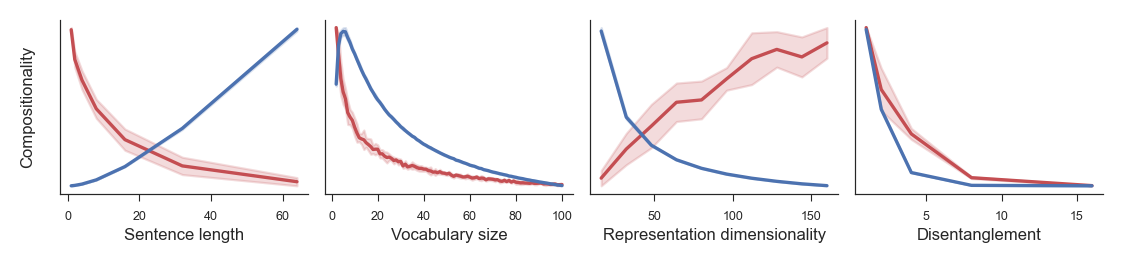

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5.5, 1.2))

experiments = {
    "Sentence length": data_sentence_length,
    "Vocabulary size": data_vocab_size,
    "Representation dimensionality": data_zdim,
    "Disentanglement": data_disentanglement,
}

for i, variable in enumerate(experiments):
    ax1, ax2 = axs[i], axs[i].twinx()
    sns.lineplot(
        data=experiments[variable],
        x=variable,
        y="Topological similarity",
        errorbar="sd",
        color=sns.color_palette()[3],
        ax=ax1,
    )
    sns.lineplot(
        data=experiments[variable],
        x=variable,
        y="Compositionality",
        errorbar="sd",
        color=sns.color_palette()[0],
        ax=ax2,
    )
    ax1.set(ylabel=None)
    ax2.set(ylabel=None)
    ax1.tick_params(axis="y", left=False, labelleft=False)
    ax2.tick_params(axis="y", right=False, labelright=False)

axs[0].set(ylabel="Compositionality")
axs[0].yaxis.set_label_coords(-0.1,0.)

plt.show()